# PROJET MACH_BDA_DATAVIZ

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt
from pathlib import Path
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [42]:
dataset = load_dataset("d0r1h/customer_churn")

df = pd.DataFrame(dataset['train'])

df_reset = df.copy() # copie pour ne pas recharger tout le dataset

In [43]:
def reset_dataframe():
    return df_reset

In [44]:
df.iloc[0]

age                                                   18
gender                                                 F
security_no                                      XW0DQ7H
region_category                                  Village
membership_category                  Platinum Membership
joining_date                                  17-08-2017
joined_through_referral                               No
referral_id                                     xxxxxxxx
preferred_offer_types              Gift Vouchers/Coupons
medium_of_operation                                    ?
internet_option                                    Wi-Fi
last_visit_time                                 16:08:02
days_since_last_login                                 17
avg_time_spent                                    300.63
avg_transaction_value                           53005.25
avg_frequency_login_days                              17
points_in_wallet                                  781.75
used_special_discount          

## Traitement des Données

In [45]:
df.isnull().sum()

age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [46]:
df.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,0.540982
std,15.867412,228.819900,398.289149,19444.806226,194.063624,0.498324
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,0.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,0.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,1.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,1.000000


In [47]:
def clean_dataframe(df):
    df.dropna(inplace=True)
    df.drop(columns=['security_no', 'referral_id'],inplace=True)
    
    df['medium_of_operation'] = df['medium_of_operation'].replace('?', 'Unknown')
    
    df = df[df['days_since_last_login'] > 0]
    df = df[df['avg_time_spent'] > 0]
    df = df[df['points_in_wallet'] > 0]
    df = df[df['avg_frequency_login_days'] != "Error"]
    
    df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'])
    
    df['joining_date'] = pd.to_datetime(df['joining_date'], format='%d-%m-%Y')
    df['last_visit_time'] = pd.to_datetime(df['last_visit_time'], format='%H:%M:%S').dt.time

    df['joining_year'] = df['joining_date'].dt.year
    df['joining_month'] = df['joining_date'].dt.month
    df['joining_day'] = df['joining_date'].dt.day

    df['last_visit_hour'] = df['last_visit_time'].apply(lambda x: x.hour)
    df['last_visit_minute'] = df['last_visit_time'].apply(lambda x: x.minute)

    df.drop(columns=['joining_date', 'last_visit_time'], inplace=True)
    
    return df

Standardisation des données numériques (mettre toutes les valeurs entre 0 et 1, pas sûr s'il y a vraiment besoin):

In [48]:
def normalize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = MinMaxScaler().fit_transform(df[numeric_columns])
    return df

Encodage des données non numériques:

In [49]:
def encode_columns(df):
    non_numeric_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    dict_encode = { value: index for index, value in enumerate(non_numeric_columns) }
    
    encoded_df = df.copy()
    
    for col in dict_encode:
        l_occurences = df[col].unique()
        dict_encode[col] = { value: index for index, value in enumerate(l_occurences) }
        encoded_df[col] = encoded_df[col].apply(lambda x : dict_encode[col][x])
    
    return encoded_df

In [50]:
df = reset_dataframe()

In [51]:
df = clean_dataframe(df)

## Analyse et visualisation exploratoire des Données

#### Matrice de corrélation pour voir si certaines features sont redondantes

In [168]:
df = encode_columns(df)

corr_matrix = df.corr().reset_index().melt('index')
corr_matrix.columns = ['Variable1', 'Variable2', 'Correlation']
corr_matrix['Correlation'] = corr_matrix['Correlation'].round(2)

heatmap = alt.Chart(corr_matrix).mark_rect().encode(
    x='Variable1:O',
    y='Variable2:O',
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='turbo')),
    tooltip=['Variable1', 'Variable2', 'Correlation']
).properties(
    width=1000,
    height=1000
)



text = heatmap.mark_text(baseline='middle').encode(
    text='Correlation:Q',
    color=alt.condition(
        alt.datum.Correlation > 0.5,
        alt.value('white'),
        alt.value('black'),
        scale=alt.Scale(domain=[0, 1], range=['black', 'white'])
    )
)
heatmap + text

alt.LayerChart(...)

In [53]:
# Activer le transformateur JSON
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

#### Age des clients

In [88]:
hist_age = alt.Chart(df_reset).mark_rect().encode(
    alt.X('age:Q', bin=alt.Bin(maxbins=30), title='Âge'),
    alt.Y('count()', title='Fréquence'),
    color=alt.Color('age', scale=alt.Scale(scheme='viridis'))
).properties(
    title='Distribution de l\'âge des clients',
    width=600,
    height=400
)

hist_age.display()

alt.Chart(...)

#### Distribution des genres

In [74]:
pie_gender = alt.Chart(df).mark_arc(outerRadius=120).encode(
    theta='count()',
    color='gender:N',
    tooltip=['gender', 'count()']
).properties(
    title='Répartition des genres'
)

pie_gender

# la partie unknown est très petite, elle est en haut avec 35 instances

alt.Chart(...)

#### Catégorie de région

In [78]:
bar_region = alt.Chart(df_reset).mark_bar().encode(
    x=alt.X('count()', title='Fréquence'),
    y=alt.Y('region_category:N', title='Catégorie de région'),
    color='region_category:N'
).properties(
    title='Distribution par catégorie de région',
    width=600,
    height=400
)

bar_region.display()

alt.Chart(...)

#### Catégorie d'abonnement

In [97]:
bar_membership = alt.Chart(df_reset).mark_bar().encode(
    x=alt.X('count()', title='Fréquence'),
    y=alt.Y('membership_category:N', title='Catégorie d\'abonnement'),
    color=alt.Color('age', scale=alt.Scale(scheme='turbo'))
).properties(
    title='Distribution par catégorie d\'abonnement',
    width=600,
    height=400
)

bar_membership.display()

alt.Chart(...)

#### Temps Moyen Passé sur le Service

In [98]:
hist_time_spent = alt.Chart(df_reset).mark_bar().encode(
    alt.X('avg_time_spent:Q', bin=alt.Bin(maxbins=30), title='Temps moyen passé (minutes)'),
    alt.Y('count()', title='Fréquence')
).properties(
    title='Distribution du temps moyen passé sur le service',
    width=600,
    height=400
)

hist_time_spent.display()

alt.Chart(...)

#### Feedback

In [149]:
feedback_counts = df['feedback'].value_counts().reset_index()
feedback_counts.columns = ['feedback', 'count']

# Créer le graphique à barres
bar_feedback = alt.Chart(feedback_counts).mark_bar().encode(
    x='feedback:N',
    y='count:Q',
    tooltip=['feedback', 'count']
).properties(
    title='Répartition des feedbacks',
    width=600,
    height=400
)

bar_feedback.display()

alt.Chart(...)

#### 

In [35]:
df.iloc[0]

age                                                   18
gender                                                 F
region_category                                  Village
membership_category                  Platinum Membership
joined_through_referral                               No
preferred_offer_types              Gift Vouchers/Coupons
medium_of_operation                              Unknown
internet_option                                    Wi-Fi
days_since_last_login                                 17
avg_time_spent                                    300.63
avg_transaction_value                           53005.25
avg_frequency_login_days                            17.0
points_in_wallet                                  781.75
used_special_discount                                Yes
offer_application_preference                         Yes
past_complaint                                        No
complaint_status                          Not Applicable
feedback                       

In [108]:
df['avg_frequency_login_days']

0        17.0
2        22.0
3         6.0
4        16.0
5        24.0
         ... 
36983    11.0
36984     2.0
36985     7.0
36986    16.0
36990    20.0
Name: avg_frequency_login_days, Length: 23044, dtype: float64

## Evaluation de plusieurs modèles avec les bonnes métriques

In [15]:
df = encode_columns(df)
df = normalize_numeric_columns(df)

In [16]:
X = df.drop(columns=['churn_risk_score'])
y = df['churn_risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'AdaBoost': AdaBoostClassifier(),
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    results[model_name] = accuracy

for model_name, accuracy in results.items():
    print(f"{model_name} Accuracy: {accuracy:.2f}")


/home/fahol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.66
SVM Accuracy: 0.71
Random Forest Accuracy: 0.94
Gradient Boosting Accuracy: 0.95
KNN Accuracy: 0.54
AdaBoost Accuracy: 0.94


Optimisation des meilleurs modèles (GDBoosting et RandomForest) pour améliorer leur accuracy:

In [17]:
# model = GradientBoostingClassifier()

# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.8, 0.9, 1.0]
# }

# random_search_gdb = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
#                                    n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42, scoring='accuracy')

# random_search_gdb.fit(X_train, y_train)

In [18]:
# print("Best parameters found: ", random_search_gdb.best_params_)

# print("Best cross-validation score: {:.2f}".format(random_search_gdb.best_score_))

# best_model_gdb = random_search_gdb.best_estimator_
# y_pred_gdb = best_model_gdb.predict(X_test)
# accuracy_gdb = accuracy_score(y_test, y_pred_gdb)

# print("Test set accuracy: {:.2f}".format(accuracy_gdb))

Best parameters found: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
Best cross-validation score: 0.94
Test set accuracy: 0.95

In [19]:
# model = RandomForestClassifier()

# param_distributions = {
#     'n_estimators': np.arange(100, 501, 50),
#     'max_depth': np.arange(3, 21, 2),
#     'min_samples_split': np.arange(2, 21, 2),
#     'min_samples_leaf': np.arange(1, 11, 1),
#     'bootstrap': [True, False]
# }

# random_search_rf = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
# random_search_rf.fit(X_train, y_train)

In [20]:
# print("Best parameters found: ", random_search_rf.best_params_)

# print("Best cross-validation score: {:.2f}".format(random_search_rf.best_score_))

# best_model_rf = random_search_rf.best_estimator_
# y_pred_rf = best_model_rf.predict(X_test)
# accuracy_rf = accuracy_score(y_test, y_pred_rf)

# print("Test set accuracy: {:.2f}".format(accuracy_rf))

Best parameters found:  {'n_estimators': 250, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_depth': 19, 'bootstrap': False}
Best cross-validation score: 0.94
Test set accuracy: 0.94

In [21]:
def features_importance(model,coeff_method=None):
    if coeff_method == 'arbres':
        feature_importances = model.feature_importances_
    else:
        feature_importances = model.coef_[0]
    
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    return feature_importance_df

In [22]:
feature_importance_df = features_importance(models['Random Forest'], 'arbres')

In [23]:
feature_importance_df

,Feature,Importance
12,points_in_wallet,0.486670
3,membership_category,0.180688
17,feedback,0.083315
10,avg_transaction_value,0.047211
11,avg_frequency_login_days,0.024370
9,avg_time_spent,0.023165
22,last_visit_minute,0.019060
0,age,0.018891
21,last_visit_hour,0.016939
20,joining_day,0.016578


## Visualiser et interpreter les résultats

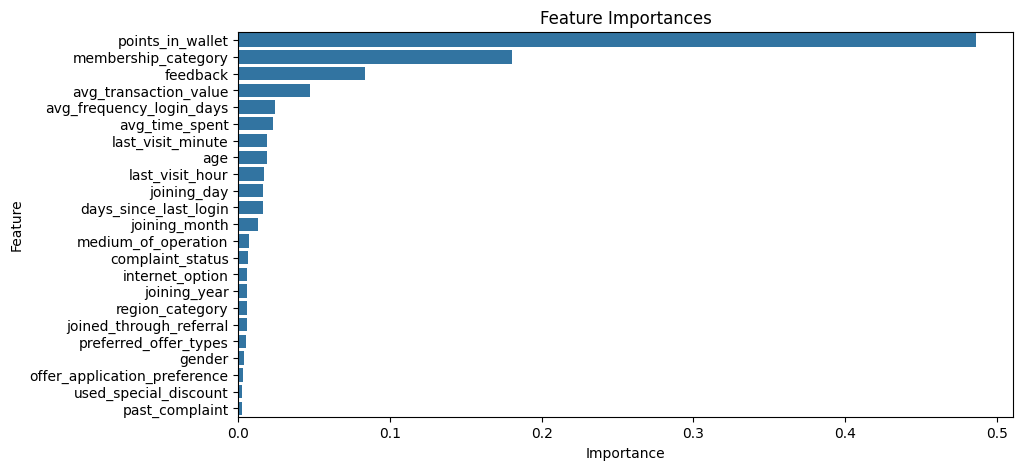

In [24]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()